In [1]:
import pandas as pd
import numpy as np
import sys
import os

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import plotly #Plotting

#GLM == General Linear Models
import scipy
import statsmodels

#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df_txt = pd.read_csv("../data_mrna_seq_v2_rsem.txt", header=None)
print(df_txt)

                                                       0
0      Hugo_Symbol\tEntrez_Gene_Id\tTCGA-A1-A0SB-01\t...
1      UBE2Q2P2\t100134869\t14.3935\t11.3241\t4.4426\...
2      HMGB1P1\t10357\t116.3870\t60.2630\t153.1452\t1...
3      LOC155060\t155060\t279.7612\t83.6986\t74.7018\...
4      RNU12-2P\t26823\t0.4505\t0.3308\t0.0000\t0.000...
...                                                  ...
20436  ZYX\t7791\t6186.7327\t3559.6725\t3007.8157\t53...
20437  ZZEF1\t23140\t1931.2986\t1278.9678\t926.3677\t...
20438  ZZZ3\t26009\t1436.1978\t1195.6000\t1075.4422\t...
20439  TPTEP1\t387590\t552.3144\t86.0144\t866.1456\t5...
20440  AKR1C6P\t389932\t0.0000\t0.0000\t0.0000\t0.856...

[20441 rows x 1 columns]


In [3]:
df_csv = TextToCsv("../data_mrna_seq_v2_rsem.txt")
print(df_csv.columns)

Shape of the CSV: (20440, 819)
Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01',
       'TCGA-A1-A0SE-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SH-01',
       'TCGA-A1-A0SI-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SK-01',
       ...
       'TCGA-LL-A5YM-01', 'TCGA-LL-A5YN-01', 'TCGA-LL-A5YO-01',
       'TCGA-LL-A5YP-01', 'TCGA-LQ-A4E4-01', 'TCGA-MS-A51U-01',
       'TCGA-OL-A66H-01', 'TCGA-OL-A66I-01', 'TCGA-OL-A66J-01',
       'TCGA-OL-A66K-01'],
      dtype='object', length=819)


In [9]:
df_counts = df_csv.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"])
df_counts = df_counts.T
df_counts = df_counts.astype(int)
print(f"Genes: {df_counts.shape[0]}, Samples: {df_counts.shape[1]}")

Genes: 817, Samples: 20440


Eliminate The values that are 0 in the rows

In [10]:
#Filtrate
df_counts = df_counts.loc[:, ~(df_counts == 0).any(axis=0)]
#df_counts = df_counts.loc[:, (df_counts > 0).sum(axis=0) >= 2] #Preguntar Manuel
print(df_counts.head())  




                 1      2      14     17     19     22     24     25     \
TCGA-A1-A0SB-01    116    279     43    392     49     37  31626    337   
TCGA-A1-A0SD-01     60     83    226    271    142     66  23793    377   
TCGA-A1-A0SE-01    153     74    299    476    192     70  15728    266   
TCGA-A1-A0SF-01    141    314    276    743    326    161  15583    441   
TCGA-A1-A0SH-01     79     95    126    353    180    130  13997    348   

                 28     30     ...  20427  20428  20429  20430  20431  20432  \
TCGA-A1-A0SB-01    711   2184  ...    614    474    321     95    519   1415   
TCGA-A1-A0SD-01    527    784  ...    367    372    648     96    578   1225   
TCGA-A1-A0SE-01    636    831  ...    367    441    810     95    726   1018   
TCGA-A1-A0SF-01   1005    442  ...    495    267    676     74    533   1053   
TCGA-A1-A0SH-01    524    820  ...    301    402    346     87    581    801   

                 20434  20435  20436  20437  
TCGA-A1-A0SB-01   1364

Before eliminating the outliers (BoxPlots) for the mRNA-Seq

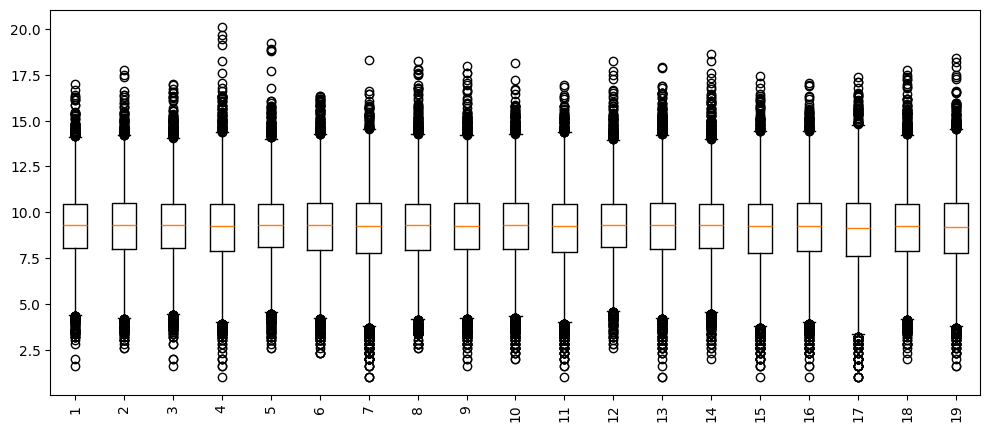

In [26]:
plt.figure(figsize=(12,5))
plt.boxplot(np.log2(df_counts[1:20].T + 1))  # transpose
plt.xticks(rotation=90)
plt.show()

Before eliminating the outliers (Histograms) for the mRNA-Seq

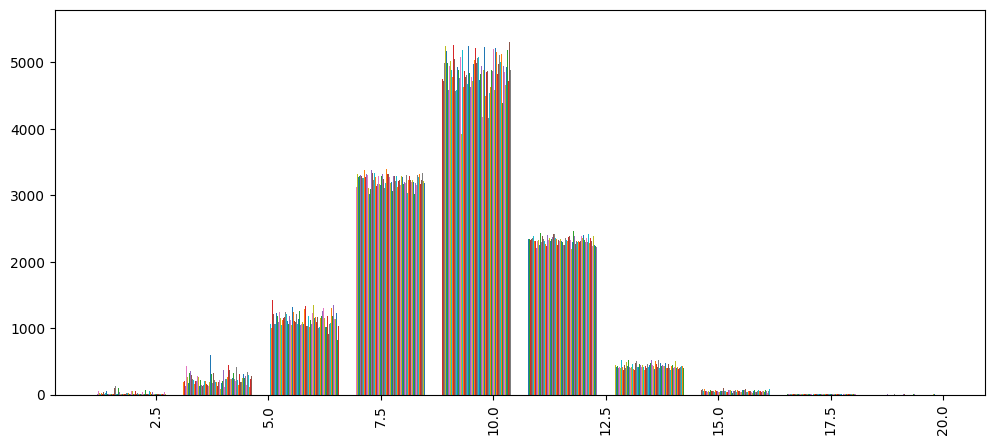

In [13]:
plt.figure(figsize=(12,5))
plt.hist(np.log2(df_counts[1:2000].T + 1))
plt.xticks(rotation=90)
plt.show()

In [58]:
n_len = len(df_counts)

conditions = ["control"]*(n_len // 2) + ["treatment"]*(n_len - n_len//2)


In [68]:

#N of Cpu
inference = DefaultInference(n_cpus=2)
metadata = pd.DataFrame({"condition":conditions}, index=df_counts.index)
print(metadata)
print(metadata.head())
print(metadata.columns)
print(metadata["condition"].values)


                 condition
TCGA-A1-A0SB-01    control
TCGA-A1-A0SD-01    control
TCGA-A1-A0SE-01    control
TCGA-A1-A0SF-01    control
TCGA-A1-A0SH-01    control
...                    ...
TCGA-MS-A51U-01  treatment
TCGA-OL-A66H-01  treatment
TCGA-OL-A66I-01  treatment
TCGA-OL-A66J-01  treatment
TCGA-OL-A66K-01  treatment

[817 rows x 1 columns]
                condition
TCGA-A1-A0SB-01   control
TCGA-A1-A0SD-01   control
TCGA-A1-A0SE-01   control
TCGA-A1-A0SF-01   control
TCGA-A1-A0SH-01   control
Index(['condition'], dtype='object')
['control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'c

In [62]:
deseqDataset = DeseqDataSet(
    counts=df_counts,
    metadata=metadata,
    design="~condition",
    inference=inference
)

deseqDataset.deseq2()

c:\Users\alexf\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.36 seconds.

Fitting dispersions...
... done in 27.65 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 28.63 seconds.

Fitting LFCs...
... done in 12.70 seconds.

Calculating cook's distance...
... done in 1.89 seconds.

Replacing 271 outlier genes.

Fitting dispersions...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 0.69 seconds.

Fitting LFCs...
... done in 0.32 seconds.



In [70]:
print(deseqDataset.layers)

Layers with keys: normed_counts, _mu_hat, cooks, replace_cooks


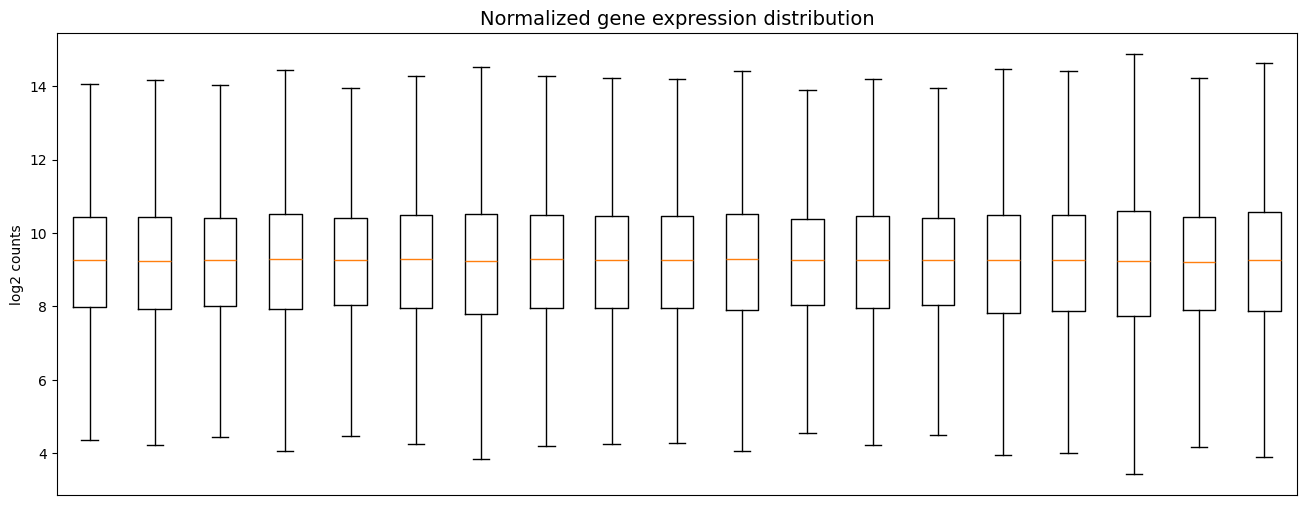

In [72]:
norm_counts = deseqDataset.layers["normed_counts"]

plt.figure(figsize=(16,6))
plt.boxplot(np.log2(norm_counts[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

In [75]:
ds = DeseqStats(deseqDataset, contrast=["condition", "control", "treatment"], inference=inference)

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: condition control vs treatment
          baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
1       116.404282        0.124258  0.043205  0.561461  0.574483   1.0
2       204.349404       -0.058339  0.065361  0.000000  1.000000   1.0
14      408.272988       -0.156729  0.085379 -0.664442  0.506407   1.0
17      492.714087        0.063090  0.051258  0.000000  1.000000   1.0
19      171.696362        0.063372  0.076582  0.000000  1.000000   1.0
...            ...             ...       ...       ...       ...   ...
20432  1126.096237        0.051993  0.023958  0.000000  1.000000   1.0
20434   935.318613       -0.021862  0.032482  0.000000  1.000000   1.0
20435  3759.215580        0.101853  0.047032  0.039392  0.968578   1.0
20436  1254.293294        0.079082  0.038951  0.000000  1.000000   1.0
20437  1006.498946       -0.079836  0.041024  0.000000  1.000000   1.0

[12330 rows x 6 columns]


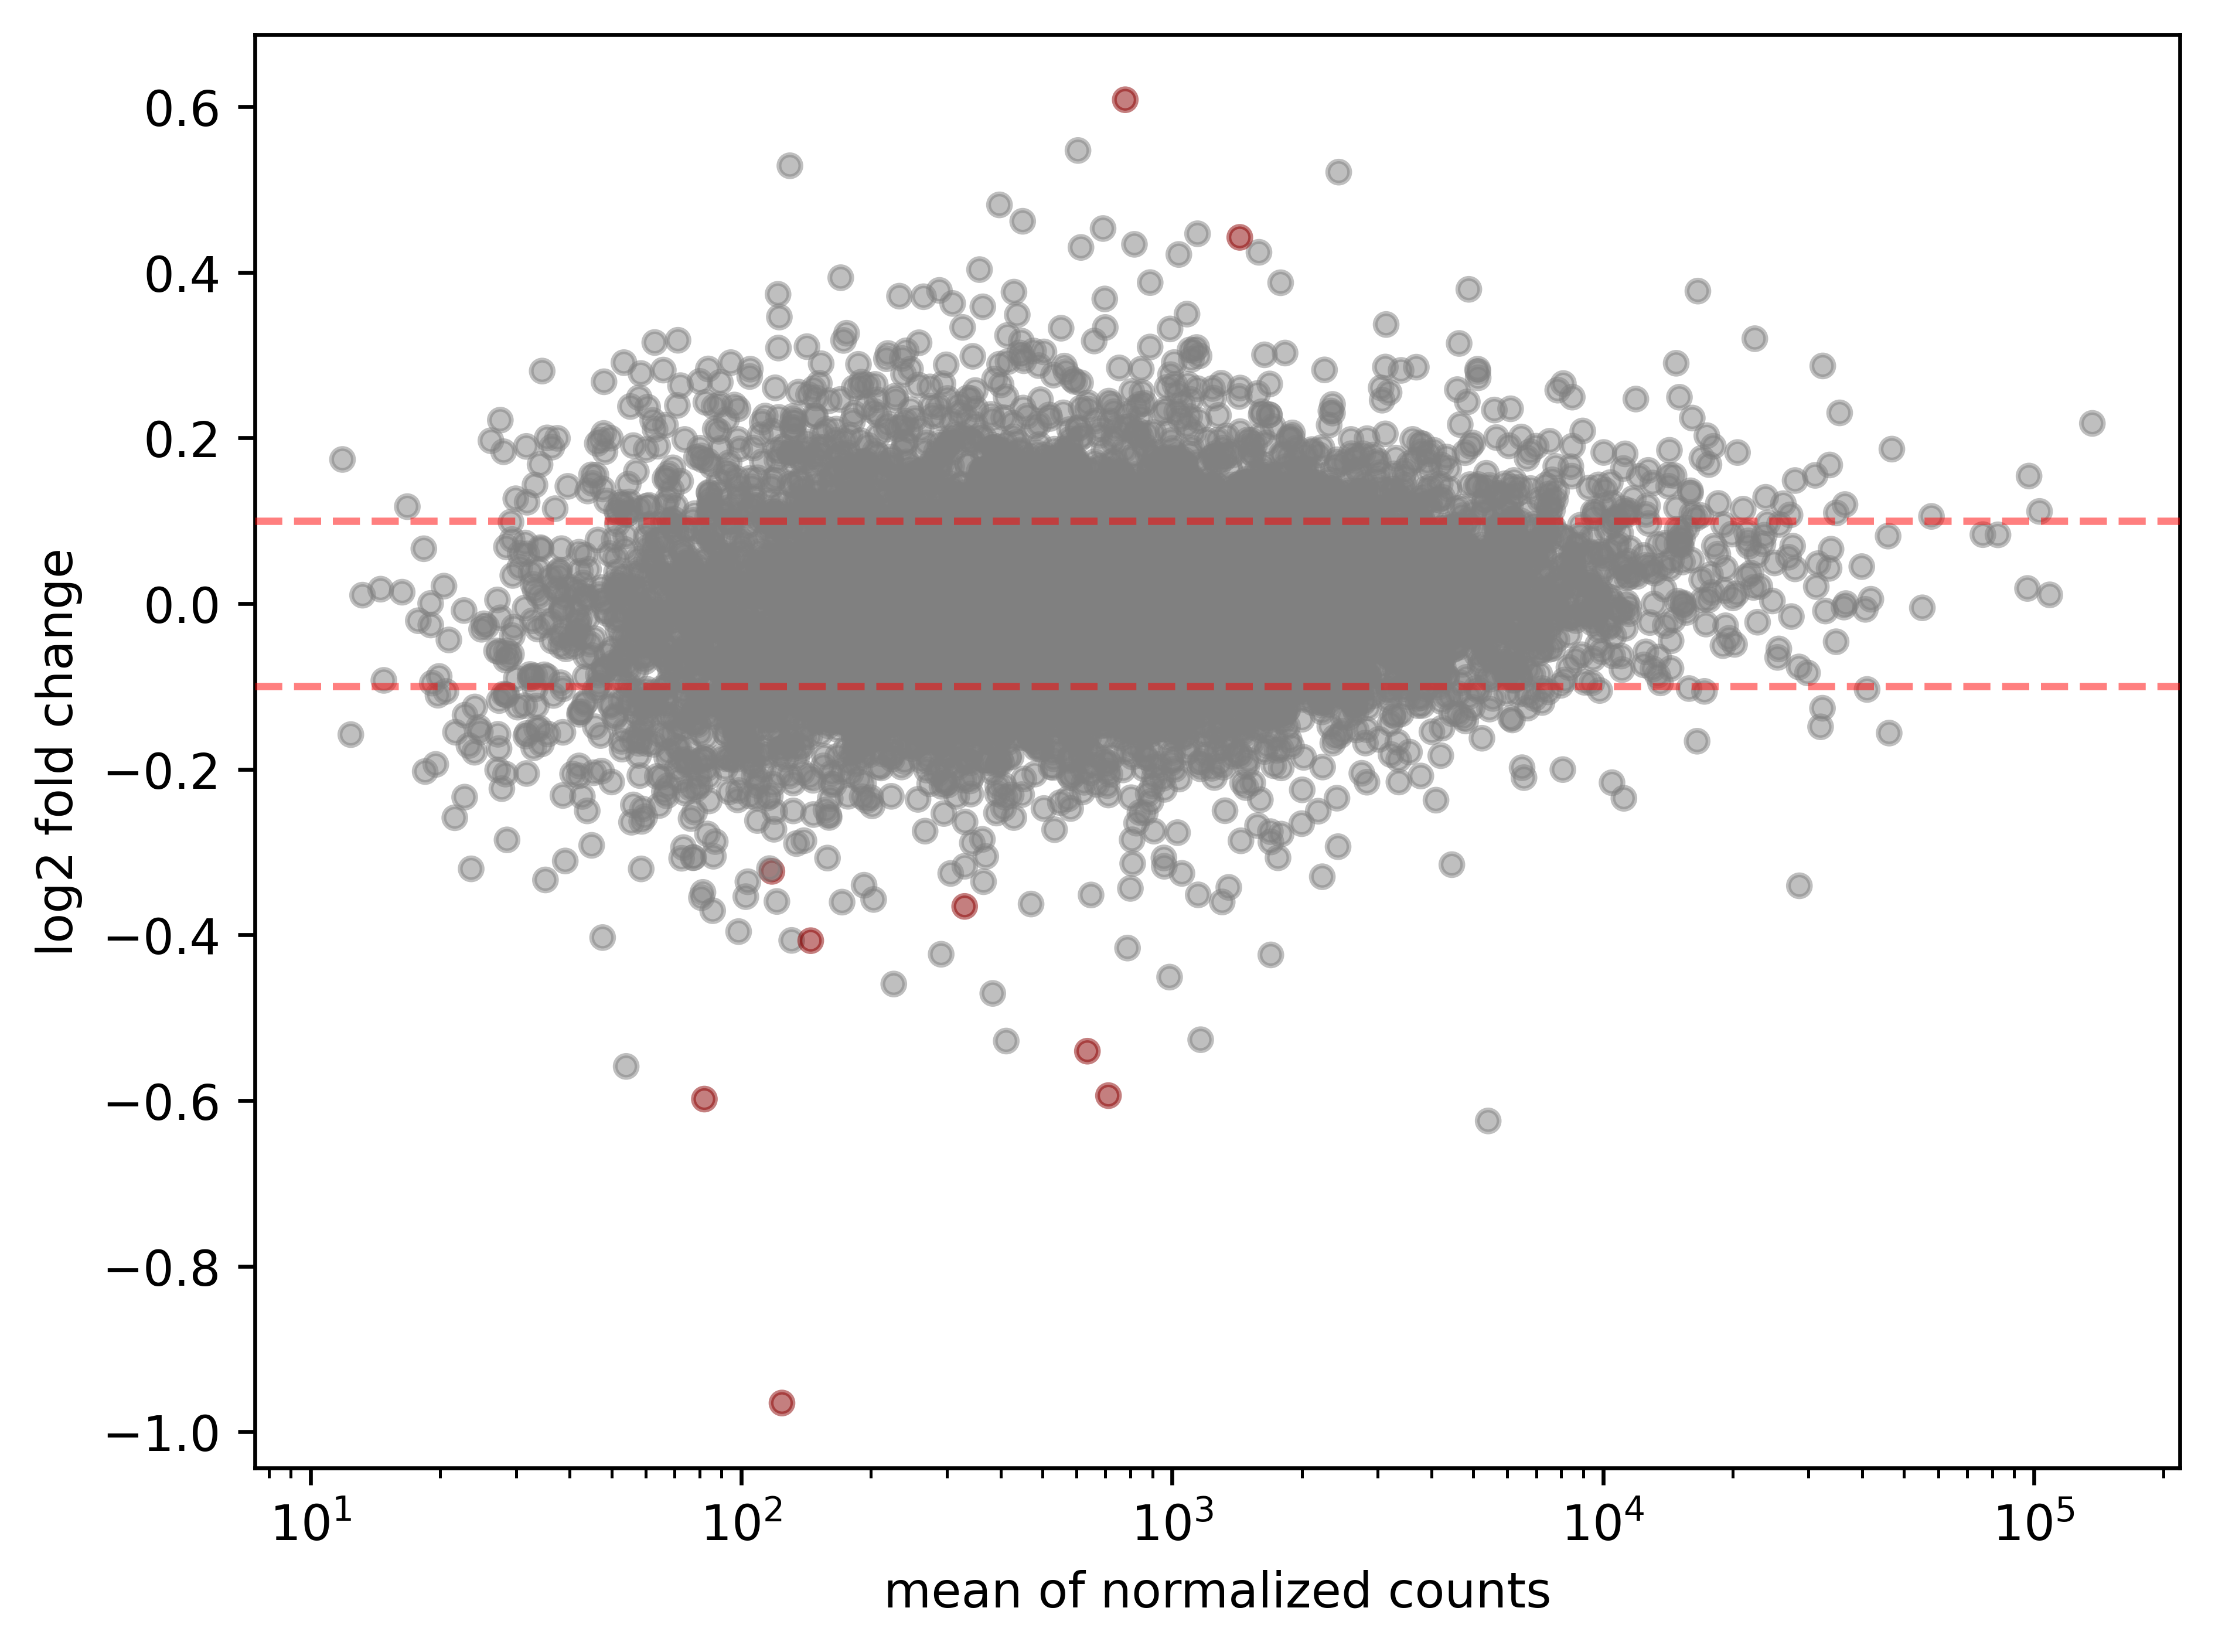

In [77]:
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)